## Бинаризация изображения методом Отсу

In [1]:
import numpy as np
import pandas as pd
import random
from PIL import Image, ImageDraw
from skimage import io
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def load_image(image_path):
    image = Image.open(image_path) #Открываем изображение. 
    draw = ImageDraw.Draw(image) #Создаем инструмент для рисования. 
    width = image.size[0] #Определяем ширину. 
    height = image.size[1] #Определяем высоту.
    pixels = image.load() #Выгружаем значения пикселей.
    gray_matrix = io.imread(image_path, as_gray=True) # матрица с уровнями серого всех пикселей
    
    return image, draw, width, height, pixels, gray_matrix

In [3]:
def gray_matrix_to_sorted_series(gray_matrix):
    pixels_array = np.reshape(gray_matrix, width*height)
    pixels_array_sorted = sorted(pixels_array)
    pixels_series_sorted = pd.Series(pixels_array_sorted)
    return pixels_series_sorted

In [4]:
def plot_pixels_hist(pixels_series_sorted, figsize = (15, 10), width =0.01):
    pixels_series_sorted.hist(bins = 75, figsize = figsize, width = width);

In [7]:
def otsu_algorithm_find_threshold(pixels_counts_series):
    pixels_counts_series = pixels_series_sorted.value_counts()
    pixels_counts_series_sorted = pixels_counts_series.sort_index(ascending = True)
    gray_levels = np.array(pixels_counts_series_sorted.index)
    numbers_of_pixels = np.array(pixels_counts_series_sorted.values)
    
    N_0 = width*height
    n = gray_levels.size
    
    w = np.zeros(n)
    for k in range(n):
        w[k] = sum(numbers_of_pixels[:k+1]) / N_0
        
    mu = np.zeros(n)
    for j in range(n):
        for i in range(j+1):
            mu[j] = mu[j] + ((numbers_of_pixels[i]/N_0)*gray_levels[i])
            
    var = np.zeros(n)
    for k in range(n-1):
        var[k] = (((mu[n-1]*w[k]) - mu[k])**2)/(w[k]*(1 - w[k]))
        
    k_star = var.argmax()
    
    threshold = gray_levels[k_star]
    
    return threshold

In [6]:
# multithresholding part
def generate_k_thresholds_list(indeces, k, res = None):
    if res == None:
        res = []

    if len(indeces) == k :
        if indeces not in res:
            res.append(indeces)
        return res
    
    if len(indeces) < k or k == 0:
        return [[]]
    
    for element in indeces:
        indeces_sublist = indeces[:]
        indeces_sublist.remove(element)
        generate_k_thresholds_list(indeces_sublist, k, res)       
    return res

def otsu_algorithm_find_thresholds(pixels_counts_series, thresholds_num):
    pixels_counts_series = pixels_series_sorted.value_counts()
    pixels_counts_series_sorted = pixels_counts_series.sort_index(ascending = True)
    gray_levels = np.array(pixels_counts_series_sorted.index)
    numbers_of_pixels = np.array(pixels_counts_series_sorted.values)
    
    N_0 = width*height
    n = gray_levels.size
    
    p = np.zeros(n)
    for k in range(n):
        p[k] = sum(numbers_of_pixels[:k+1]) / N_0
        
    indeces = list(range(n))
    thresholds_list = generate_k_thresholds_list(indeces, thresholds_num)
    ip = [gray_levels[i] * p[i] for i in range(len(p))]
    mu_t = sum(ip)
    
    sigmas = []
    for thresholds in thresholds_list:
        cur_p = p
        cur_ip = ip
        sigma = []
        for threshold in thresholds:
            w_cur = sum(cur_p[:threshold + 1])
            mu_cur = sum(cur_ip[:threshold + 1]) / w_cur
            sigma.append(w_cur * (mu_cur - mu_t) ** 2)
            cur_p = cur_p[threshold + 1:]
            cur_ip = cur_ip[threshold + 1:]
        sigmas.append(sum(sigma))
        
        
    optimal_indeces = thresholds_list[sigmas.argmax()]
    
    
    
    thresholds = [gray_levels[index] for index in optimal_indeces]
    
    return threshold

In [18]:
def binarize_image(draw, pixels, gray_level_threshold, gray_matrix):
    for i in range(width):
        for j in range(height):
            red = pixels[i, j][0]
            green = pixels[i, j][1]
            blue = pixels[i, j][2]
            if (gray_matrix[j, i] > gray_level_threshold):
                red, green, blue = 255, 255, 255
            else:
                red, green, blue = 0, 0, 0
            draw.point((i, j), (red, green, blue))
    

## ЭЭЭЭКсперименты

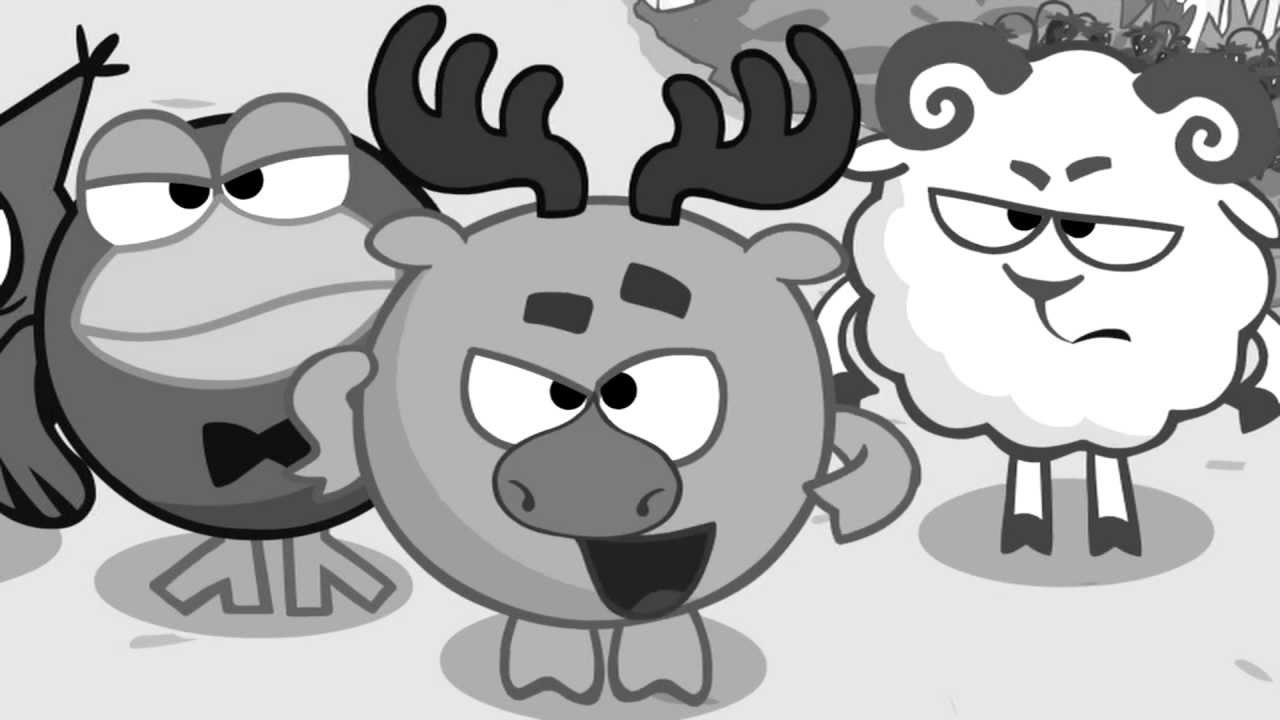

In [10]:
image, draw, width, height, pixels, gray_matrix = load_image('maxresdefault.jpg')
image

In [11]:
pixels_series_sorted = gray_matrix_to_sorted_series(gray_matrix)

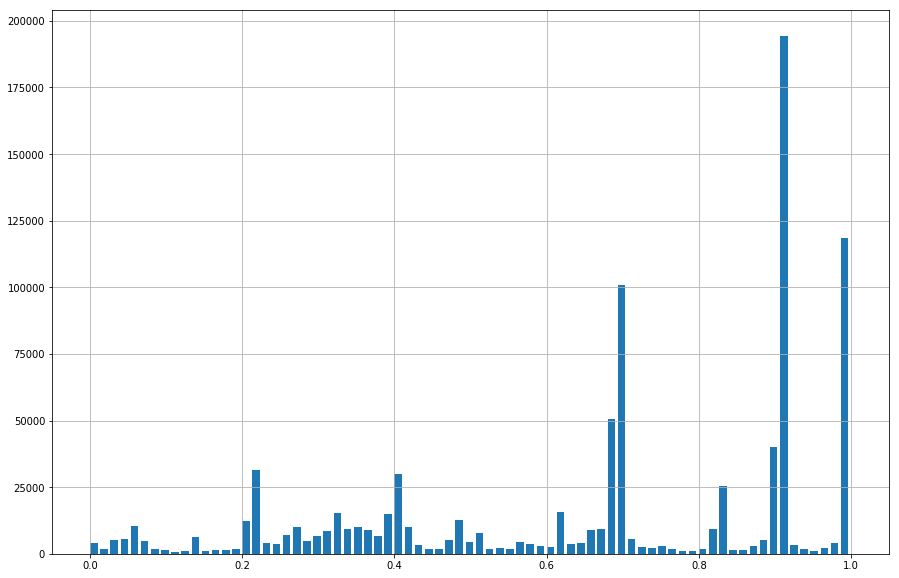

In [12]:
plot_pixels_hist(pixels_series_sorted)

In [15]:
gray_level_threshold = otsu_algorithm_find_threshold(pixels_series_sorted)

In [19]:
binarize_image(draw, pixels, gray_level_threshold, gray_matrix)

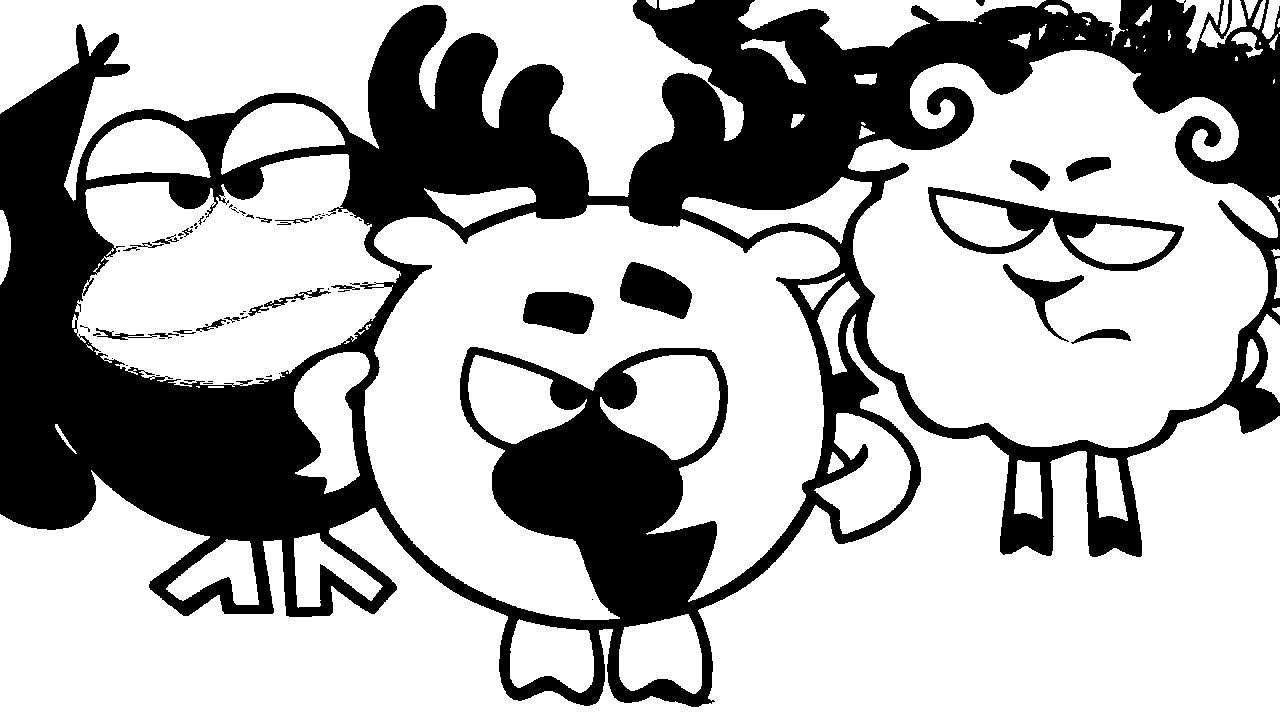

In [20]:
image.save("ans.jpg", "JPEG")
image